In [1]:
"""
The purpose of this Jupyter notebook is to ...
"""

'\nThe purpose of this Jupyter notebook is to ...\n'

In [2]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
# Load the latest version of the screen subset TSV file
path_to_subset_tsv = (
    "Dharmacon_pooled_G1_G2_screening_plates_subset_with_missing_"
    "UniProt_IDs_Z-scored.tsv"
)

dp_g1_g2_subset_df = pd.read_csv(
    path_to_subset_tsv,
    sep="\t"
)

In [3]:
# Extract controls from the DataFrame
# Omit the control type "UNKNOWN" while doing so
# Note that in the case of controls, the column `ID_openBIS` has to be
# used for indexing in lieu of `Name`
# This stems from the fact that, naturally, many controls names do not
# occur in the NCBI Entrez database files (such as SCRAMBLED or MOCK),
# causing the corresponding fields in the `Name` column to be `NaN`
controls_df = dp_g1_g2_subset_df[
    (dp_g1_g2_subset_df["WellType"] == "CONTROL")
    &
    (dp_g1_g2_subset_df["ID_openBIS"] != "UNKNOWN")
]

In [4]:
# Determine the unique control names
unique_control_names = controls_df[
    "ID_openBIS"
].drop_duplicates().to_list()

n_controls = len(unique_control_names)

print(
    f"In total, there are {n_controls} different controls. These are:"
)

for control_name in unique_control_names:
    print(control_name)

In total, there are 12 different controls. These are:
ATP6V1A
SCRAMBLED
MOCK
PSMC3
KIF11
PSMA6
TSG101
GFP
RAC1
ARPC3
CDC42
PAK1


In [5]:
# The big objective of this Jupyter notebook is to assess the stability
# of measurements across different plates
# To this end, controls are analyzed
# For each control and plate, one value is obtained per intensity
# measurement
# As the controls occur multiple times per plate, this is accomplished
# by computing the mean per plate within the respective intensity
# measurement
# Thus, the next step consists of multi-level grouping followed by
# computation of the mean
# Multi-level grouping is done for the plate ID (`Barcode`) as well as
# the control name (`ID_openBIS`)
grouped_df = controls_df.groupby(["Barcode", "ID_openBIS"])

# Index the columns of interest (the different intensity measurements
# for eGFP and mCherry) and compute the mean for each intensity
# measurement separately
mean_int_per_plate_and_control_df = grouped_df[[
    "dIntensity_cPathogen_eMean_oCells_nZScore",
    "dIntensity_cPathogen_eMean_oNuclei_nZScore",
    "dIntensity_cPathogen_eMean_oPeriNuclei_nZScore",
    "dIntensity_cPathogen_eMean_oVoronoiCells_nZScore",
    "dIntensity_cLatePathogen_eMean_oCells_nZScore",
    "dIntensity_cLatePathogen_eMean_oNuclei_nZScore",
    "dIntensity_cLatePathogen_eMean_oPeriNuclei_nZScore",
    "dIntensity_cLatePathogen_eMean_oVoronoiCells_nZScore"
]].mean()

### Comparing Raw Intensities with Z-Scored Intensities

In [43]:
# Compute the mean as well as the standard deviation per raw measurement
# type for all controls
control_groups = controls_df.groupby("ID_openBIS")

raw_measurement_types = [
    "dIntensity_cPathogen_eMean_oNuclei",
    "dIntensity_cPathogen_eMean_oPeriNuclei",
    "dIntensity_cPathogen_eMean_oCells",
    "dIntensity_cPathogen_eMean_oVoronoiCells",
    "dIntensity_cLatePathogen_eMean_oNuclei",
    "dIntensity_cLatePathogen_eMean_oPeriNuclei",
    "dIntensity_cLatePathogen_eMean_oCells",
    "dIntensity_cLatePathogen_eMean_oVoronoiCells"
]

control_names = []
raw_mean_list = []
raw_std_list = []

for name, group in control_groups:
    control_names.append(name)
    current_mean = group[raw_measurement_types].mean().to_list()
    current_std = group[raw_measurement_types].std().to_list()
    raw_mean_list.append(current_mean)
    raw_std_list.append(current_std)

for name, mean_list, std_list in zip(
    control_names, raw_mean_list, raw_std_list
):
    print(f"Raw intensities for control {name}:")
    for measurement_type, mean_val, std_val in zip(
        raw_measurement_types,
        mean_list,
        std_list
    ):
        print(
            f"{measurement_type}:".ljust(46) + f"{mean_val:.4}" + " ± " + f"{std_val:.4}"
        )

Raw intensities for control ARPC3:
dIntensity_cPathogen_eMean_oNuclei:           0.06572 ± 0.01381
dIntensity_cPathogen_eMean_oPeriNuclei:       0.06058 ± 0.0127
dIntensity_cPathogen_eMean_oCells:            0.03043 ± 0.00761
dIntensity_cPathogen_eMean_oVoronoiCells:     0.05756 ± 0.012
dIntensity_cLatePathogen_eMean_oNuclei:       0.04422 ± 0.007097
dIntensity_cLatePathogen_eMean_oPeriNuclei:   0.04338 ± 0.007039
dIntensity_cLatePathogen_eMean_oCells:        0.01606 ± 0.001671
dIntensity_cLatePathogen_eMean_oVoronoiCells: 0.04322 ± 0.007023
Raw intensities for control ATP6V1A:
dIntensity_cPathogen_eMean_oNuclei:           0.07232 ± 0.01596
dIntensity_cPathogen_eMean_oPeriNuclei:       0.06575 ± 0.0145
dIntensity_cPathogen_eMean_oCells:            0.03428 ± 0.009237
dIntensity_cPathogen_eMean_oVoronoiCells:     0.06194 ± 0.01356
dIntensity_cLatePathogen_eMean_oNuclei:       0.04589 ± 0.007303
dIntensity_cLatePathogen_eMean_oPeriNuclei:   0.04438 ± 0.007128
dIntensity_cLatePathogen_eMea

In [42]:
# Now, do the same thing for the Z-scored intensities
Z_scored_measurement_types = [
    measurement_type + "_nZScore"
    for measurement_type in raw_measurement_types
]

Z_scored_mean_list = []
Z_scored_std_list = []

for _, group in control_groups:
    current_mean = group[Z_scored_measurement_types].mean().to_list()
    current_std = group[Z_scored_measurement_types].std().to_list()
    Z_scored_mean_list.append(current_mean)
    Z_scored_std_list.append(current_std)

for name, mean_list, std_list in zip(
    control_names, Z_scored_mean_list, Z_scored_std_list
):
    print(f"Z-scored intensities for control {name}:")
    for measurement_type, mean_val, std_val in zip(
        Z_scored_measurement_types,
        mean_list,
        std_list
    ):
        print(
            f"{measurement_type}:".ljust(54)
            +
            f"{mean_val:.4}"
            +
            " ± "
            +
            f"{std_val:.4}"
        )

Z-scored intensities for control ARPC3:
dIntensity_cPathogen_eMean_oNuclei_nZScore:           -0.4608 ± 0.5555
dIntensity_cPathogen_eMean_oPeriNuclei_nZScore:       -0.2992 ± 0.6433
dIntensity_cPathogen_eMean_oCells_nZScore:            -0.22 ± 0.6406
dIntensity_cPathogen_eMean_oVoronoiCells_nZScore:     -0.2053 ± 0.685
dIntensity_cLatePathogen_eMean_oNuclei_nZScore:       -0.4494 ± 0.7323
dIntensity_cLatePathogen_eMean_oPeriNuclei_nZScore:   -0.1278 ± 0.9435
dIntensity_cLatePathogen_eMean_oCells_nZScore:        -0.1137 ± 1.02
dIntensity_cLatePathogen_eMean_oVoronoiCells_nZScore: -0.04124 ± 1.005
Z-scored intensities for control ATP6V1A:
dIntensity_cPathogen_eMean_oNuclei_nZScore:           0.4175 ± 0.7624
dIntensity_cPathogen_eMean_oPeriNuclei_nZScore:       0.6201 ± 0.8747
dIntensity_cPathogen_eMean_oCells_nZScore:            0.5794 ± 0.8707
dIntensity_cPathogen_eMean_oVoronoiCells_nZScore:     0.7296 ± 0.948
dIntensity_cLatePathogen_eMean_oNuclei_nZScore:       0.7383 ± 1.104
dIntens

### Visual Stability Assessment For Conventional Z-Scoring

#### Z-Scored Intensities

In [6]:
# The most convenient way of generating a bar plot with a superimposed
# scatter consists of using the Seaborn library
# Unfortunately, Seaborn's `barplot` function does not directly operate
# on pre-computed mean and standard deviation values, but on the raw
# data
# Additionally, the raw data has to meet certain requirements regarding
# the format:
# When creating a bar plot, two variable (i.e. column) names of a
# DataFrame must be provided
# The variable passed as x-coordinate determines the categories of the
# bars and therefore their number
# In other words, for each unique value in the column passed as
# x-coordinate, one separate bar is created
# The function of the variable passed as y-coordinate is
# self-explanatory
# In order to meet this requirement, the DataFrame has to be reshaped
# To be more precise, the column names indicating the measurement type
# need to be converted into values of a new column
# This is accomplished via the `.melt()` method, which transforms a
# DataFrame from wide to long format
# However, prior to using `.melt()`, the column names indicating the
# measurement type are renamed for simplicity
renaming_dict = {
    "dIntensity_cPathogen_eMean_oCells_nZScore": "early_Cells",
    "dIntensity_cPathogen_eMean_oNuclei_nZScore": "early_Nuclei",
    "dIntensity_cPathogen_eMean_oPeriNuclei_nZScore": "early_PeriNuclei",
    "dIntensity_cPathogen_eMean_oVoronoiCells_nZScore": "early_VoronoiCells",
    "dIntensity_cLatePathogen_eMean_oCells_nZScore": "late_Cells",
    "dIntensity_cLatePathogen_eMean_oNuclei_nZScore": "late_Nuclei",
    "dIntensity_cLatePathogen_eMean_oPeriNuclei_nZScore": "late_PeriNuclei",
    "dIntensity_cLatePathogen_eMean_oVoronoiCells_nZScore": "late_VoronoiCells"
}

mean_int_per_plate_and_control_df = (
    mean_int_per_plate_and_control_df
    .reset_index()
    .rename(columns=renaming_dict)
    .melt(
        id_vars=["Barcode", "ID_openBIS"],
        var_name="measurement",
        value_name="mean_Z_scored_intensity"
    )
)

In [ ]:
# Create a new directory to store the image(s) in
image_dir_name = (
    "measurement_stability_bar_plots_with_scatter/conventional_Z_scoring"
)
if not os.path.exists(image_dir_name):
    os.makedirs(image_dir_name)

In [9]:
measurement_types = [
    "early_Cells",
    "early_Nuclei",
    "early_PeriNuclei",
    "early_VoronoiCells",
    "late_Cells",
    "late_Nuclei",
    "late_PeriNuclei",
    "late_VoronoiCells"
]

In [10]:
mean_ints_grouped_by_control = (
    mean_int_per_plate_and_control_df.groupby("ID_openBIS")
)

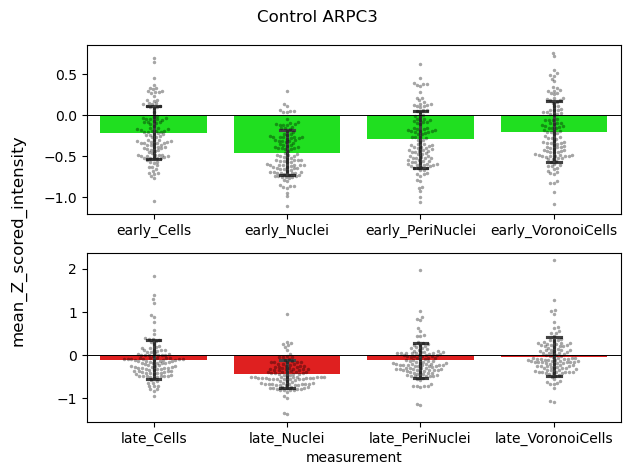

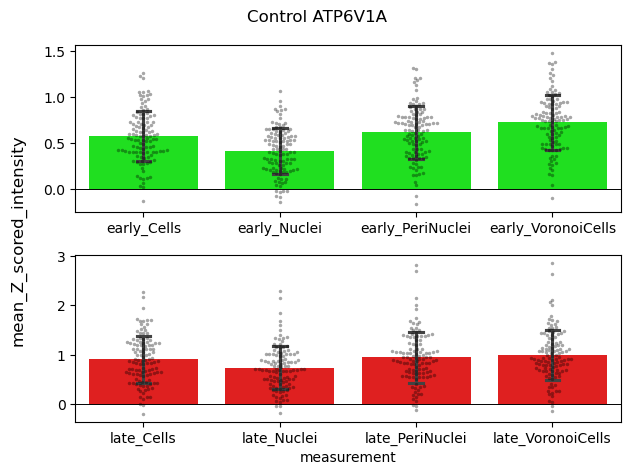

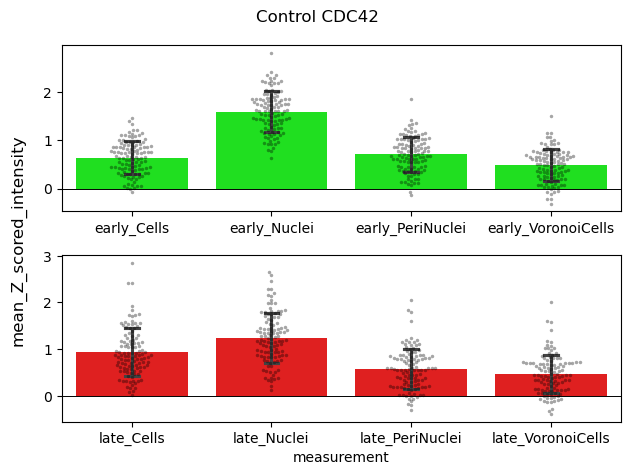

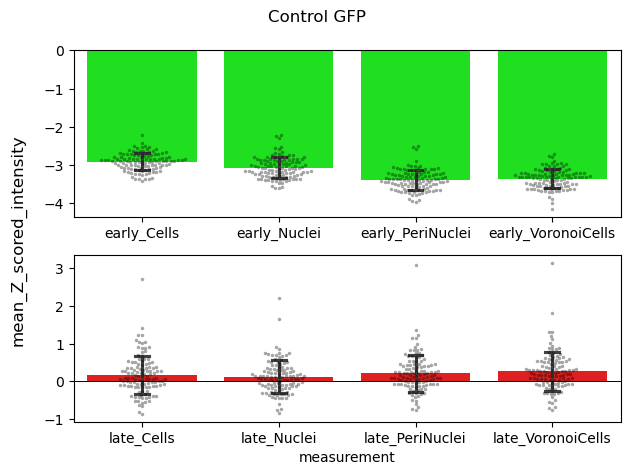

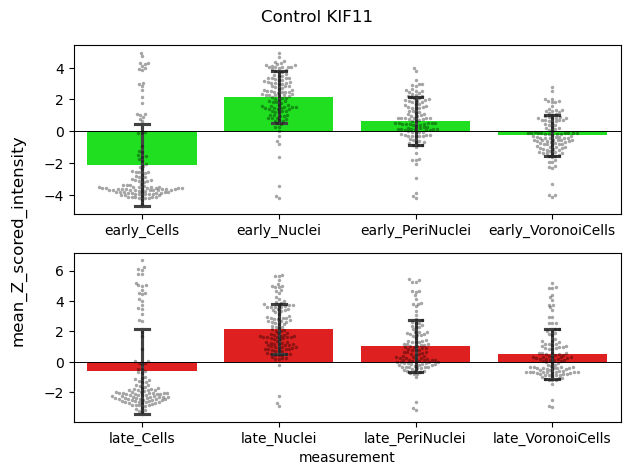

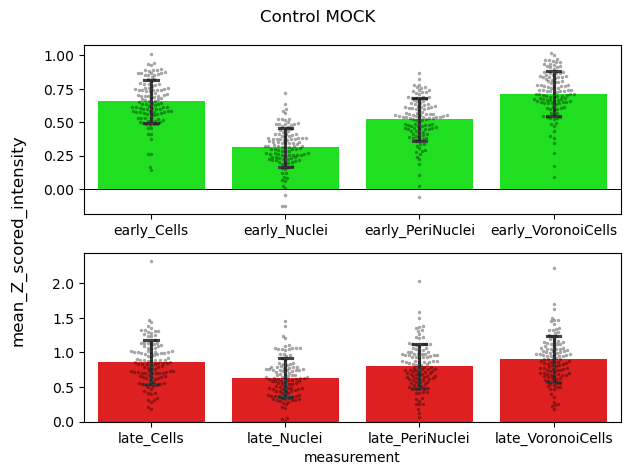

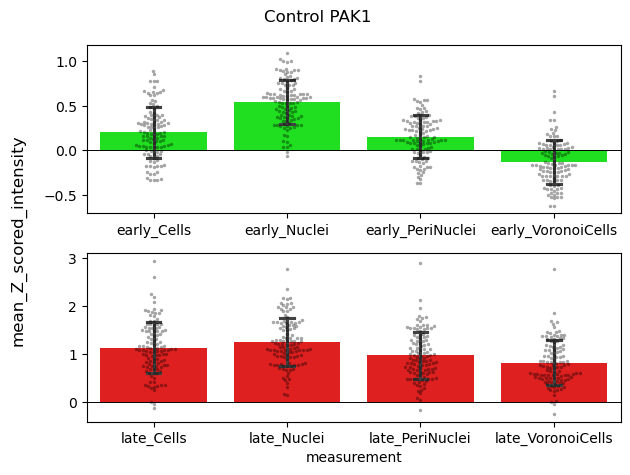

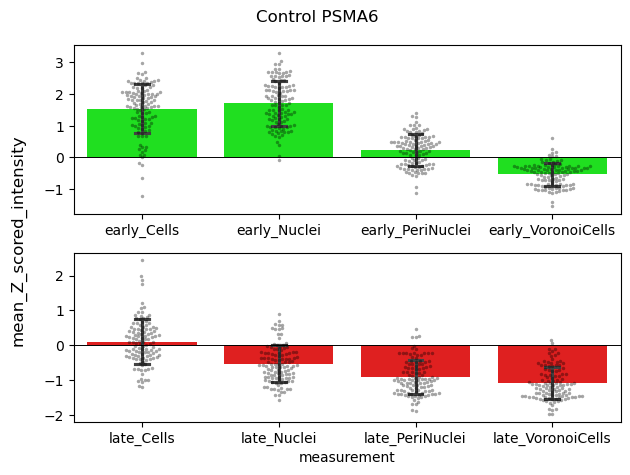

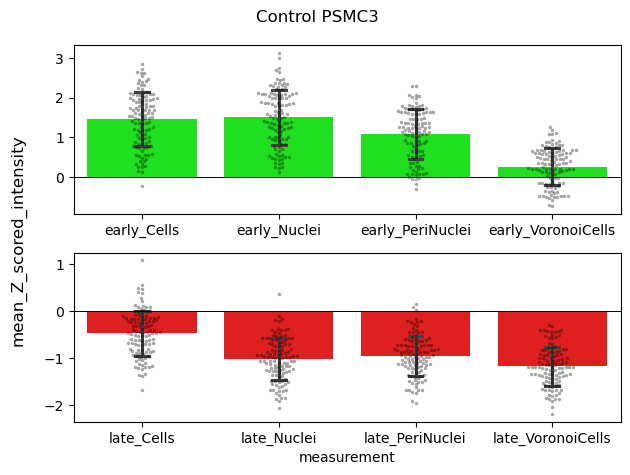

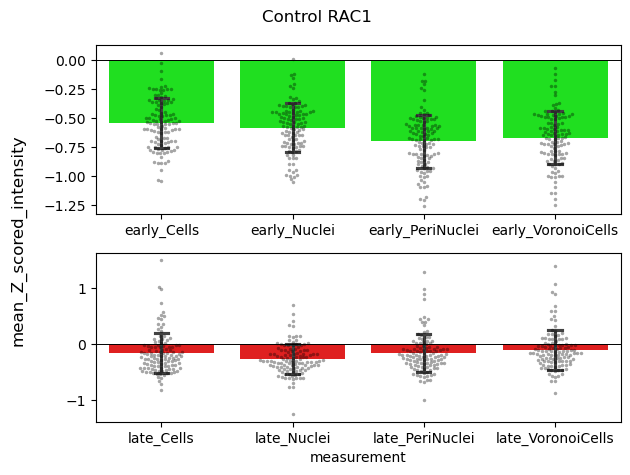

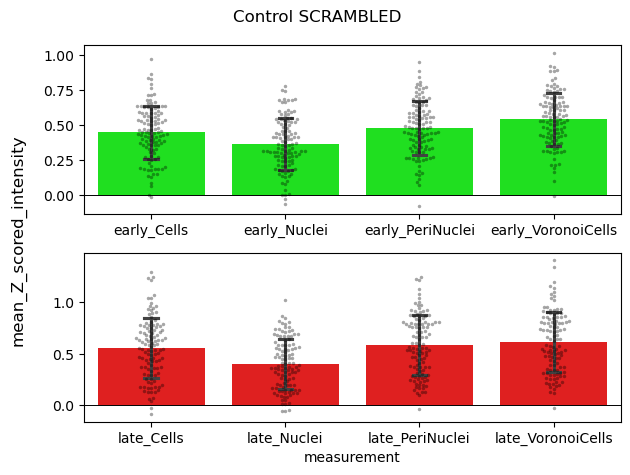

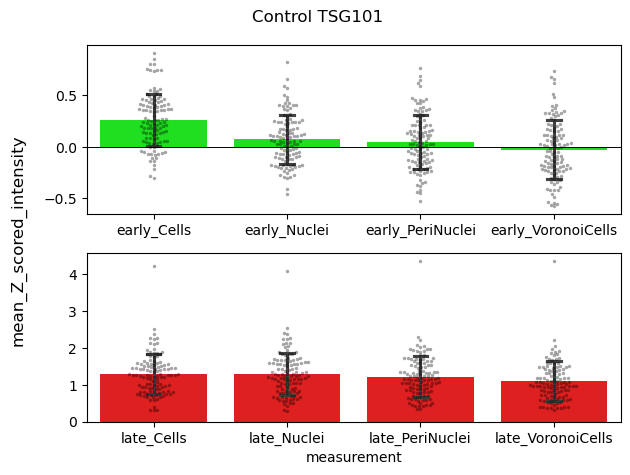

In [ ]:
# Now, turn to the generation of the plots
# Iterate over the 12 controls
for control_name, group in mean_ints_grouped_by_control:
    # There are eight measurement types in total (cells, nuclei,
    # perinuclei and Voronoi cells for early and late each)
    # Thus, for each control, eight bars are generated
    # These eight bars are split between two subplots such that each
    # subplot has four bars
    early_ints_df = group.loc[
        group["measurement"].isin(measurement_types[:4])
    ]
    late_ints_df = group.loc[
        group["measurement"].isin(measurement_types[4:])
    ]

    fig, (ax1, ax2) = plt.subplots(2, 1)
    sns.barplot(
        data=early_ints_df,
        x="measurement",
        y="mean_Z_scored_intensity",
        capsize=.1,
        errorbar="sd",
        color="lime",
        ax=ax1
    )
    ax1.xaxis.get_label().set_visible(False)
    ax1.yaxis.get_label().set_visible(False)
    ax1.axhline(color="black", linewidth=0.7)
    sns.swarmplot(
        data=early_ints_df,
        x="measurement",
        y="mean_Z_scored_intensity",
        color="0", # "0" equals black
        alpha=.35, # The alpha value controls the transparency
        size=2.5,
        ax=ax1
    )

    sns.barplot(
        data=late_ints_df,
        x="measurement",
        y="mean_Z_scored_intensity",
        capsize=.1,
        errorbar="sd",
        color="red",
        ax=ax2
    )
    ax2.yaxis.get_label().set_visible(False)
    ax2.axhline(color="black", linewidth=0.7)
    sns.swarmplot(
        data=late_ints_df,
        x="measurement",
        y="mean_Z_scored_intensity",
        color="0",
        alpha=.35,
        size=2.5,
        ax=ax2
    )

    fig.supylabel("mean_Z_scored_intensity")

    fig.suptitle(f"Control {control_name}")

    plt.tight_layout()
    # plt.show()

    # Do not forget to save the image; by using the explicit API,
    # accessing the image is also possible after `plt.show()`
    image_path = os.path.join(
        image_dir_name,
        f"bar_plot_with_scatter_{control_name}.png"
    )
    fig.savefig(
        image_path,
        dpi=300
    )

#### Raw Intensities

In [45]:
# Do the same procedure for the raw intensities
raw_renaming_dict = {
    "dIntensity_cPathogen_eMean_oCells": "early_Cells",
    "dIntensity_cPathogen_eMean_oNuclei": "early_Nuclei",
    "dIntensity_cPathogen_eMean_oPeriNuclei": "early_PeriNuclei",
    "dIntensity_cPathogen_eMean_oVoronoiCells": "early_VoronoiCells",
    "dIntensity_cLatePathogen_eMean_oCells": "late_Cells",
    "dIntensity_cLatePathogen_eMean_oNuclei": "late_Nuclei",
    "dIntensity_cLatePathogen_eMean_oPeriNuclei": "late_PeriNuclei",
    "dIntensity_cLatePathogen_eMean_oVoronoiCells": "late_VoronoiCells"
}

raw_mean_int_per_plate_and_control_df = grouped_df[[
    "dIntensity_cPathogen_eMean_oCells",
    "dIntensity_cPathogen_eMean_oNuclei",
    "dIntensity_cPathogen_eMean_oPeriNuclei",
    "dIntensity_cPathogen_eMean_oVoronoiCells",
    "dIntensity_cLatePathogen_eMean_oCells",
    "dIntensity_cLatePathogen_eMean_oNuclei",
    "dIntensity_cLatePathogen_eMean_oPeriNuclei",
    "dIntensity_cLatePathogen_eMean_oVoronoiCells"
]].mean()

In [46]:
raw_mean_int_per_plate_and_control_df = (
    raw_mean_int_per_plate_and_control_df
    .reset_index()
    .rename(columns=raw_renaming_dict)
    .melt(
        id_vars=["Barcode", "ID_openBIS"],
        var_name="measurement",
        value_name="mean_raw_intensity"
    )
)

In [47]:
# Create a new directory to store the images in
raw_vals_image_dir_name = (
    "measurement_stability_bar_plots_with_scatter/raw_values"
)
if not os.path.exists(raw_vals_image_dir_name):
    os.makedirs(raw_vals_image_dir_name)

In [48]:
raw_mean_ints_grouped_by_control = (
    raw_mean_int_per_plate_and_control_df.groupby("ID_openBIS")
)

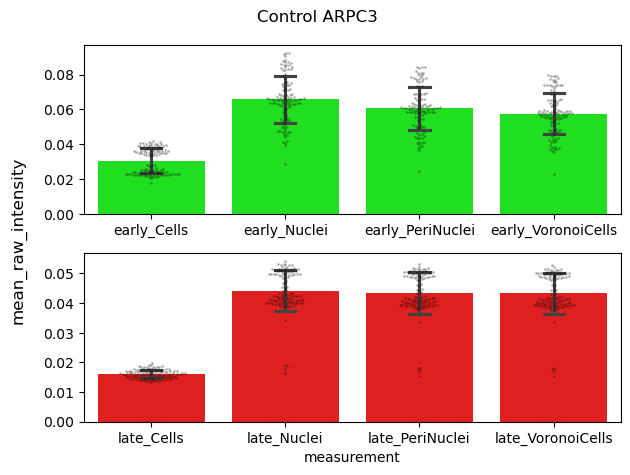

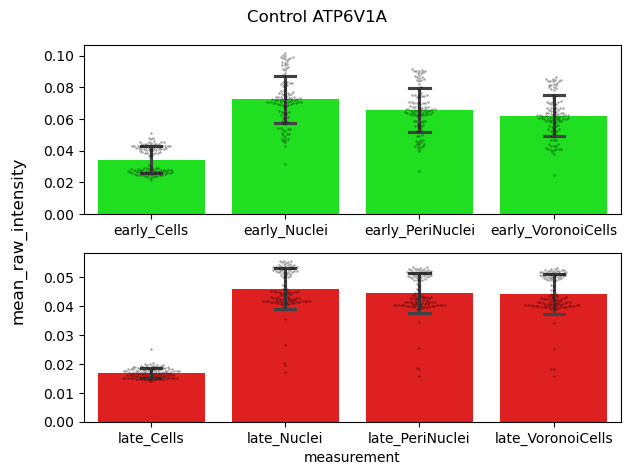

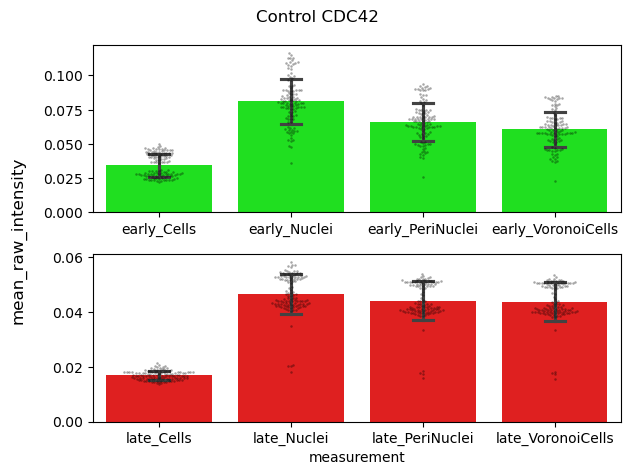

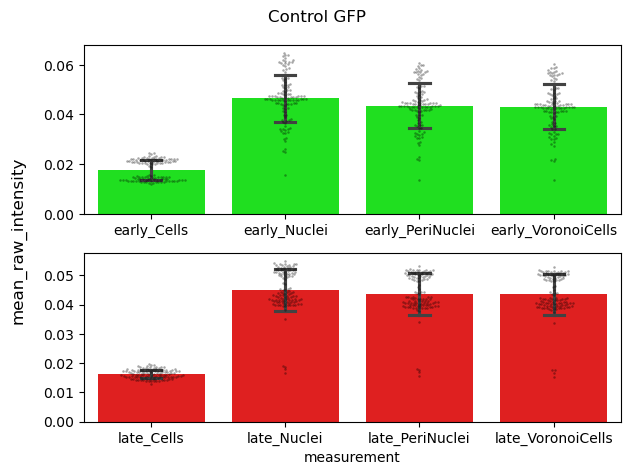

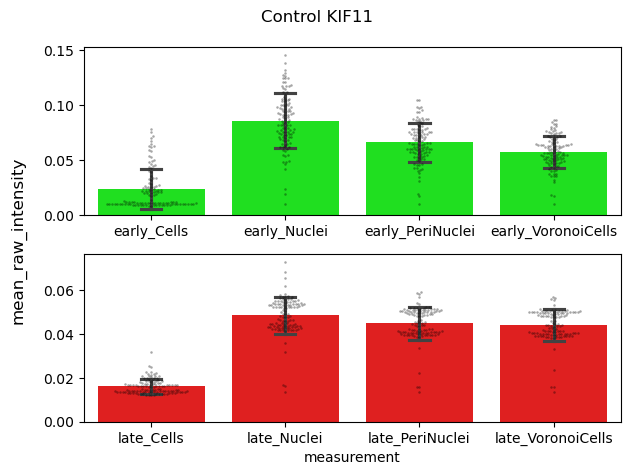

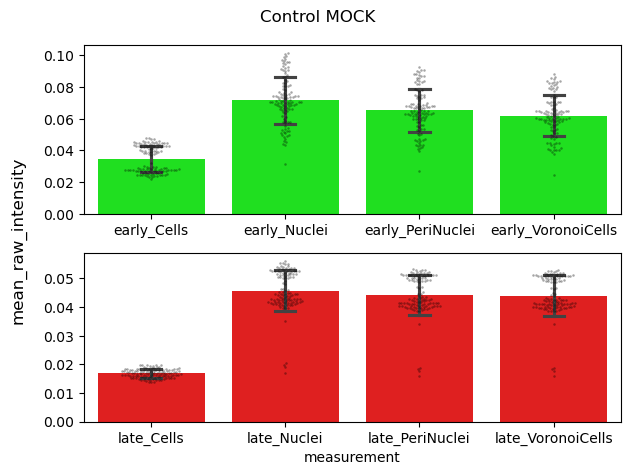

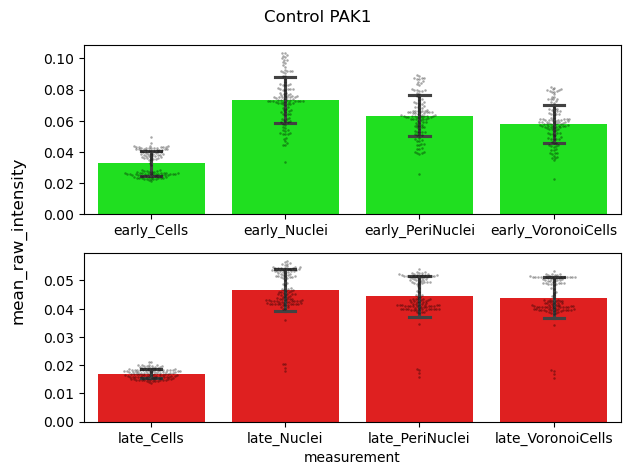

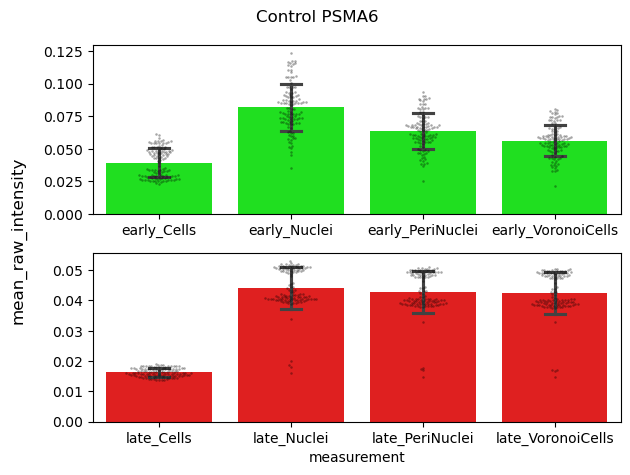

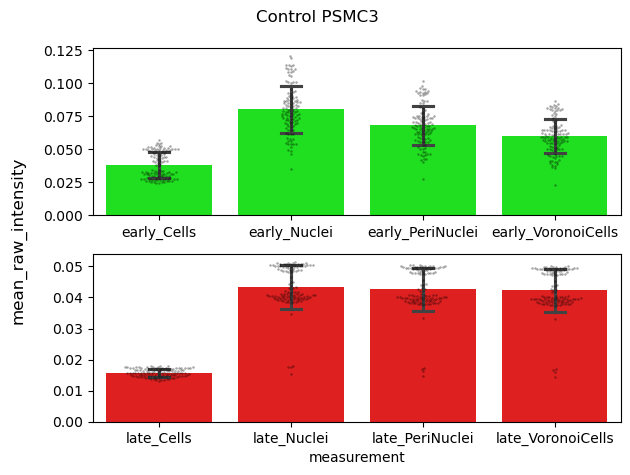

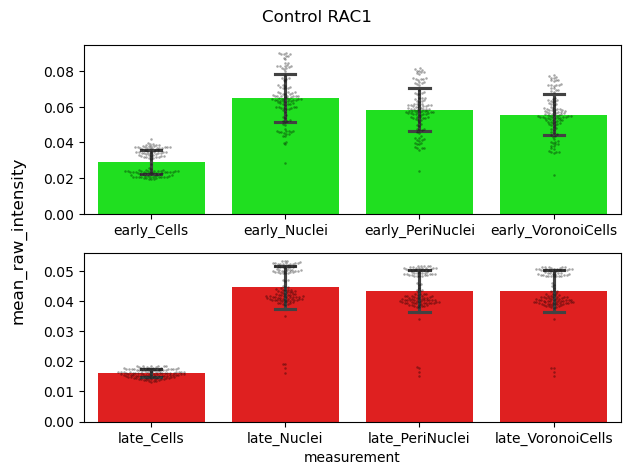

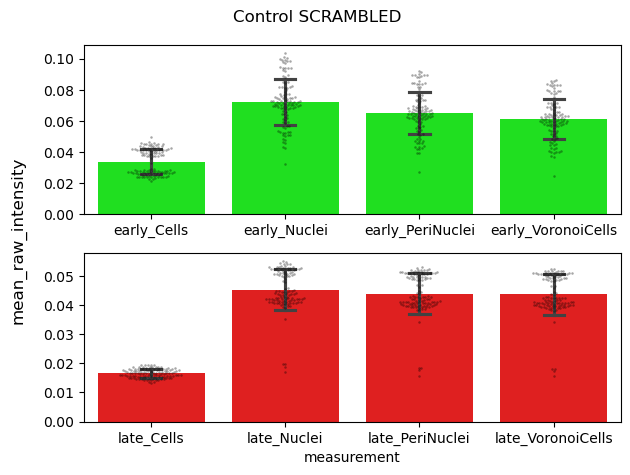

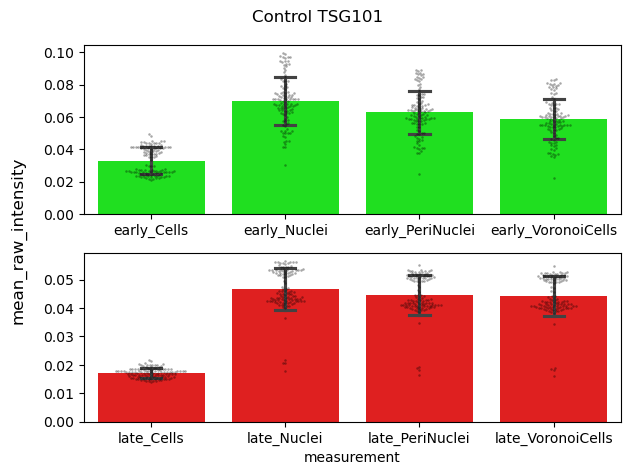

In [55]:
# Now, turn to the generation of the plots
# Iterate over the 12 controls
for control_name, group in raw_mean_ints_grouped_by_control:
    early_ints_df = group.loc[
        group["measurement"].isin(measurement_types[:4])
    ]
    late_ints_df = group.loc[
        group["measurement"].isin(measurement_types[4:])
    ]

    fig, (ax1, ax2) = plt.subplots(2, 1)
    sns.barplot(
        data=early_ints_df,
        x="measurement",
        y="mean_raw_intensity",
        capsize=0.15,
        errorbar="sd",
        color="lime",
        ax=ax1
    )
    ax1.xaxis.get_label().set_visible(False)
    ax1.yaxis.get_label().set_visible(False)
    ax1.axhline(color="black", linewidth=0.7)
    sns.swarmplot(
        data=early_ints_df,
        x="measurement",
        y="mean_raw_intensity",
        color="0",
        alpha=.35,
        size=1.8,
        ax=ax1
    )

    sns.barplot(
        data=late_ints_df,
        x="measurement",
        y="mean_raw_intensity",
        capsize=0.15,
        errorbar="sd",
        color="red",
        ax=ax2
    )
    ax2.yaxis.get_label().set_visible(False)
    ax2.axhline(color="black", linewidth=0.7)
    sns.swarmplot(
        data=late_ints_df,
        x="measurement",
        y="mean_raw_intensity",
        color="0",
        alpha=.35,
        size=1.8,
        ax=ax2
    )

    fig.supylabel("mean_raw_intensity")

    fig.suptitle(f"Control {control_name}")

    plt.tight_layout()
    # plt.show()

    image_path = os.path.join(
        raw_vals_image_dir_name,
        f"bar_plot_with_scatter_{control_name}.png"
    )
    fig.savefig(
        image_path,
        dpi=300
    )

### Defining Utilities

In [11]:
def generate_bar_plots_with_scatter_per_control(
        input_df, image_dir, capsize=0.1, markersize=2.5
):
    """
    Generates bar plots with scatter for individual controls.

    To this end, the input DataFrame is brought into the correct format
    to be plotted. In detail, this function performs multi-level
    grouping for the plate ID (`Barcode`) as well as the control name
    (`ID_openBIS). This multi-level grouping allows the computation of
    the mean intensity for each control per plate within the respective
    intensity measurement. Accordingly, the input DataFrame is expected
    to have a `Barcode` column as well as a `ID_openBIS` column.

    Subsequent to this multi-level grouping and mean computation, the
    DataFrame has to be formatted in a specific way. This stems from the
    fact that Seaborn's `barplot` function does not directly operate on
    pre-computed mean and standard deviation values, but on the raw
    data. Additionally, the raw data has to meet certain requirements
    regarding the format:
    When creating a bar plot, two variable (i.e. column) names of a
    DataFrame must be provided. The variable passed as x-coordinate
    determines the categories of the bars and therefore their number. In
    other words, for each unique value in the column passed as
    x-coordinate, one separate bar is created. Accordingly, the variable
    passed as y-coordinate determines the heigth of the individual bars.

    In order to meet this requirement, the DataFrame has to be reshaped.
    To be more precise, the column names indicating the measurement type
    need to be converted into values of a new column. This is
    accomplished via the `.melt()` method, which transforms a DataFrame
    from wide to long format.

    Parameters
    ----------
    input_df: Pandas DataFrame
        Pandas DataFrame storing the data to visualize.
    image_dir: str
        A string denoting the path of the directory to store the images
        in.
    capsize: float, optional
        Width of the caps on error bars in the bar plot. Default value
        is 0.1.
    markersize: float, optional
        Radius of the markers in the swarmplot. Default value is 2.5.

    Returns
    -------
    None
    """
    # Extract the controls from the input DataFrame
    # Omit the control type "UNKNOWN" while doing so
    controls_df = input_df[
        (input_df["WellType"] == "CONTROL")
        &
        (input_df["ID_openBIS"] != "UNKNOWN")
    ]

    # Perform multi-level grouping
    grouped_df = controls_df.groupby(["Barcode", "ID_openBIS"])

    # Index the columns of interest (the different intensity
    # measurements for eGFP and mCherry) and compute the mean for each
    # intensity measurement separately
    mean_int_per_plate_and_control_df = grouped_df[[
        "dIntensity_cPathogen_eMean_oCells_nZScore",
        "dIntensity_cPathogen_eMean_oNuclei_nZScore",
        "dIntensity_cPathogen_eMean_oPeriNuclei_nZScore",
        "dIntensity_cPathogen_eMean_oVoronoiCells_nZScore",
        "dIntensity_cLatePathogen_eMean_oCells_nZScore",
        "dIntensity_cLatePathogen_eMean_oNuclei_nZScore",
        "dIntensity_cLatePathogen_eMean_oPeriNuclei_nZScore",
        "dIntensity_cLatePathogen_eMean_oVoronoiCells_nZScore"
    ]].mean()

    # Prior to DataFrame formatting, the column names indicating the
    # measurement type are renamed for simplicity
    renaming_dict = {
        "dIntensity_cPathogen_eMean_oCells_nZScore": "early_Cells",
        "dIntensity_cPathogen_eMean_oNuclei_nZScore": "early_Nuclei",
        "dIntensity_cPathogen_eMean_oPeriNuclei_nZScore": "early_PeriNuclei",
        "dIntensity_cPathogen_eMean_oVoronoiCells_nZScore": "early_VoronoiCells",
        "dIntensity_cLatePathogen_eMean_oCells_nZScore": "late_Cells",
        "dIntensity_cLatePathogen_eMean_oNuclei_nZScore": "late_Nuclei",
        "dIntensity_cLatePathogen_eMean_oPeriNuclei_nZScore": "late_PeriNuclei",
        "dIntensity_cLatePathogen_eMean_oVoronoiCells_nZScore": "late_VoronoiCells"
    }

    # Bring the DataFrame into the format required for plotting
    mean_int_per_plate_and_control_df = (
        mean_int_per_plate_and_control_df
        .reset_index()
        .rename(columns=renaming_dict)
        .melt(
            id_vars=["Barcode", "ID_openBIS"],
            var_name="measurement",
            value_name="mean_Z_scored_intensity"
        )
    )

    # Create a new directory to store the image(s) in
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
    
    measurement_types = [
        "early_Cells",
        "early_Nuclei",
        "early_PeriNuclei",
        "early_VoronoiCells",
        "late_Cells",
        "late_Nuclei",
        "late_PeriNuclei",
        "late_VoronoiCells"
    ]

    mean_ints_grouped_by_control = (
        mean_int_per_plate_and_control_df.groupby("ID_openBIS")
    )

    # Now, turn to the generation of the plots
    # Iterate over the 12 controls
    for control_name, group in mean_ints_grouped_by_control:
        # There are eight measurenent types in total (cells, nuclei,
        # perinuclei and Voronoi cells for early and leate each)
        # Thus, for each control, eight bars are generated
        # These eight bars are split between two subplots such that each
        # subplot has four bars
        early_ints_df = group.loc[
            group["measurement"].isin(measurement_types[:4])
        ]
        late_ints_df = group.loc[
            group["measurement"].isin(measurement_types[4:])
        ]

        fig, (ax1, ax2) = plt.subplots(2, 1)
        sns.barplot(
            data=early_ints_df,
            x="measurement",
            y="mean_Z_scored_intensity",
            capsize=capsize,
            errorbar="sd",
            color="lime",
            ax=ax1
        )
        ax1.xaxis.get_label().set_visible(False)
        ax1.yaxis.get_label().set_visible(False)
        ax1.axhline(color="black", linewidth=0.7)
        sns.swarmplot(
            data=early_ints_df,
            x="measurement",
            y="mean_Z_scored_intensity",
            color="0", # "0" equals black
            alpha=.35, # The alpha value controls the transparency
            size=markersize,
            ax=ax1
        )

        sns.barplot(
            data=late_ints_df,
            x="measurement",
            y="mean_Z_scored_intensity",
            capsize=capsize,
            errorbar="sd",
            color="red",
            ax=ax2
        )
        ax2.yaxis.get_label().set_visible(False)
        ax2.axhline(color="black", linewidth=0.7)
        sns.swarmplot(
            data=late_ints_df,
            x="measurement",
            y="mean_Z_scored_intensity",
            color="0",
            alpha=.35,
            size=markersize,
            ax=ax2
        )

        fig.supylabel("mean_Z_scored_intensity")

        fig.suptitle(f"Control {control_name}")

        plt.tight_layout()

        # Do not forget to save the image; by using the explicit API,
        # accessing the image is also possible after `plt.show()`
        image_path = os.path.join(
            image_dir,
            f"bar_plot_with_scatter_{control_name}.png"
        )
        fig.savefig(
            image_path,
            dpi=300
        )

### Visual Stability Assessment for B-Score Normalization

In [12]:
# As the gene contents of individual plates differ, conventional
# Z-scoring might not be the best choice
# In total, three alternatives to conventional Z-scoring are tested
# The first of them is B-score normalization, the purpose of which is to
# correct for systematic spatial effects in a microtiter plate

# Load the corresponding version of the subset TSV file
path_to_b_scored_subet_tsv = (
    "Dharmacon_pooled_G1_G2_screening_plates_subset_with_missing_"
    "UniProt_IDs_B_score_normalized.tsv"
)

dp_g1_g2_b_scored_subset_df = pd.read_csv(
    path_to_b_scored_subet_tsv,
    sep="\t"
)

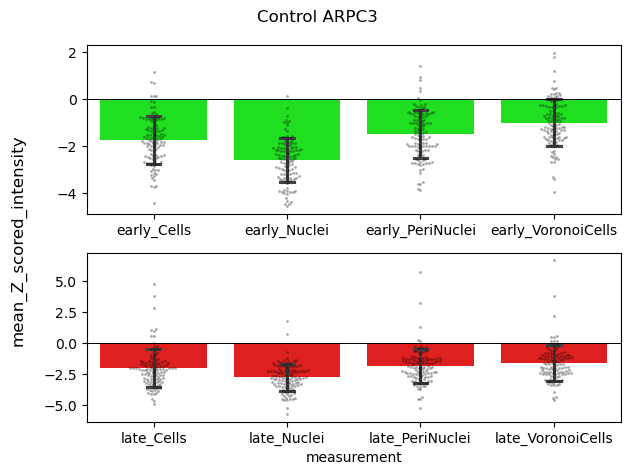

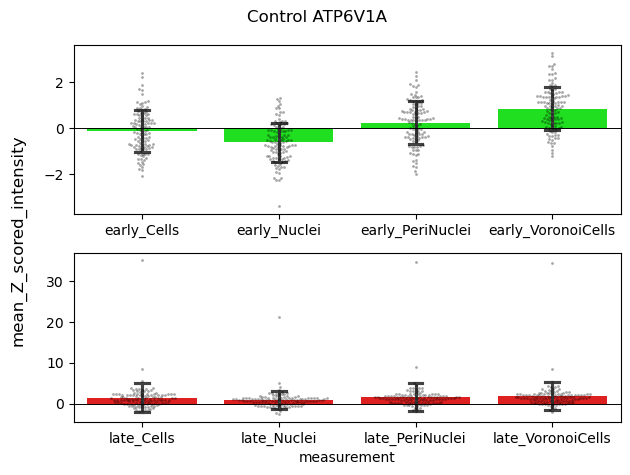

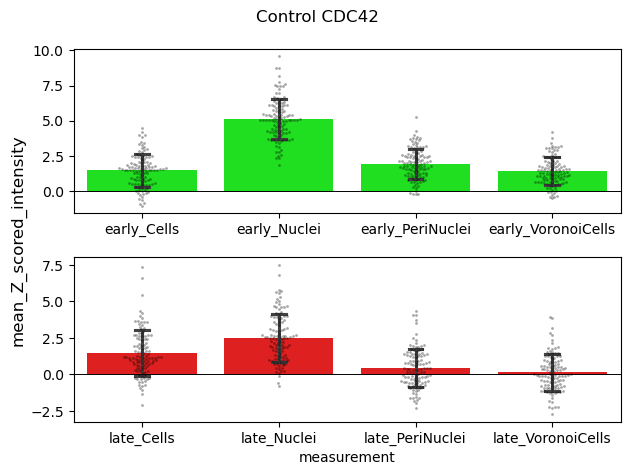

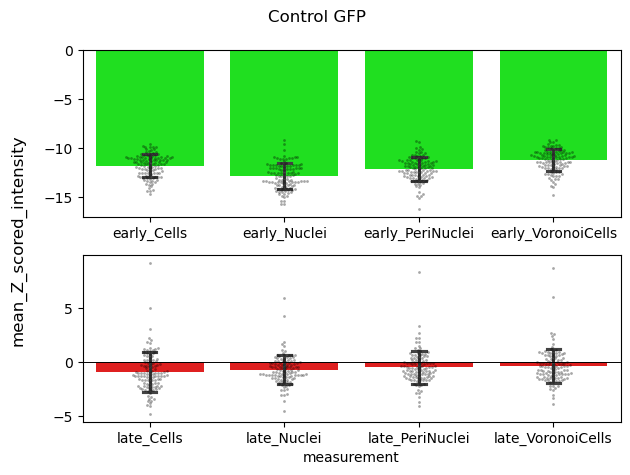

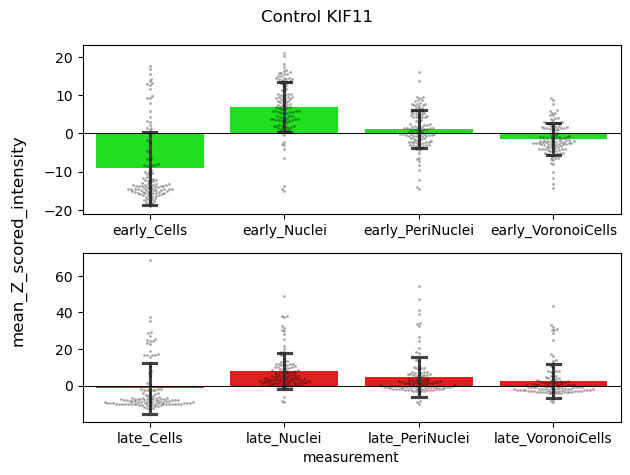

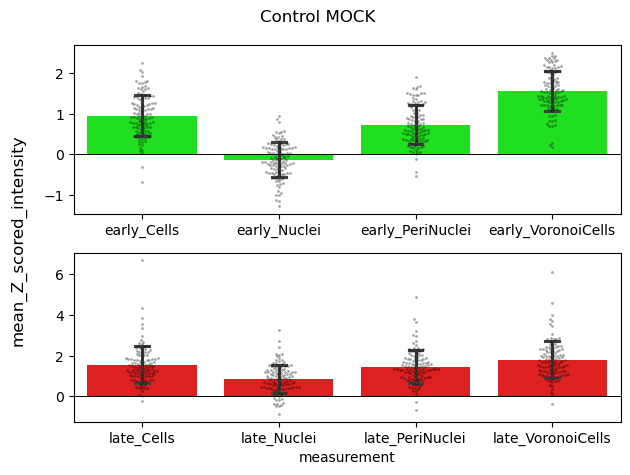

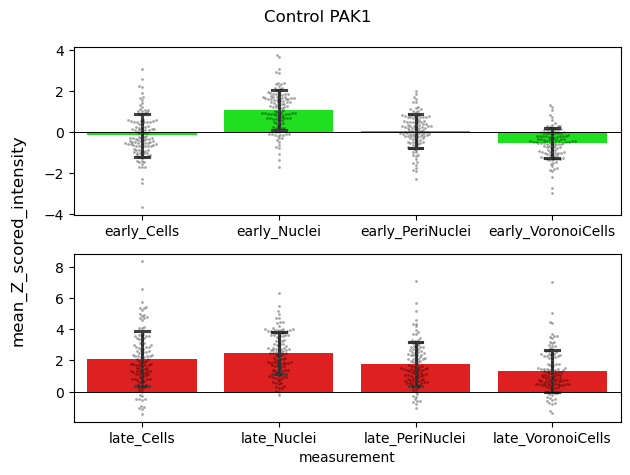

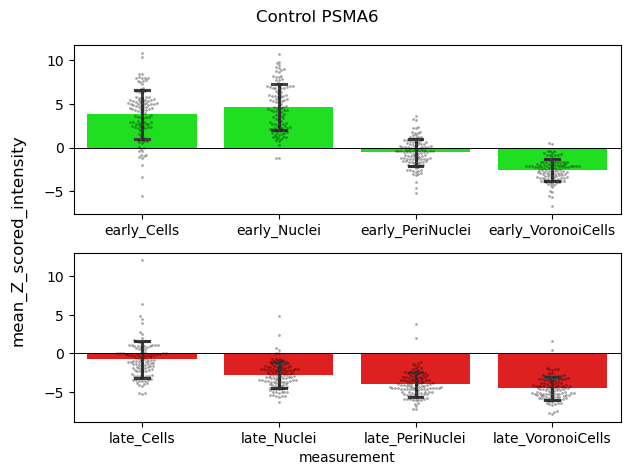

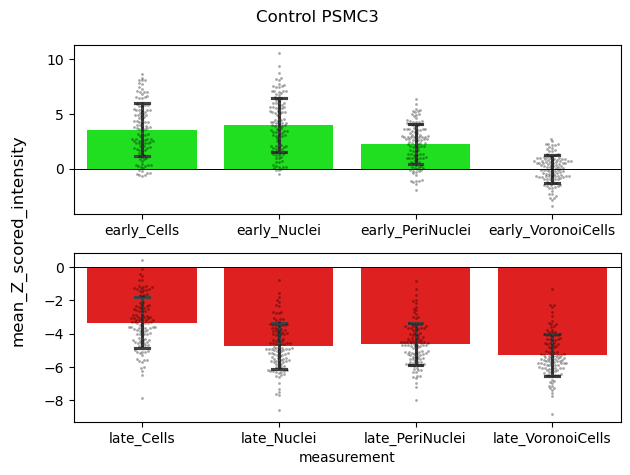

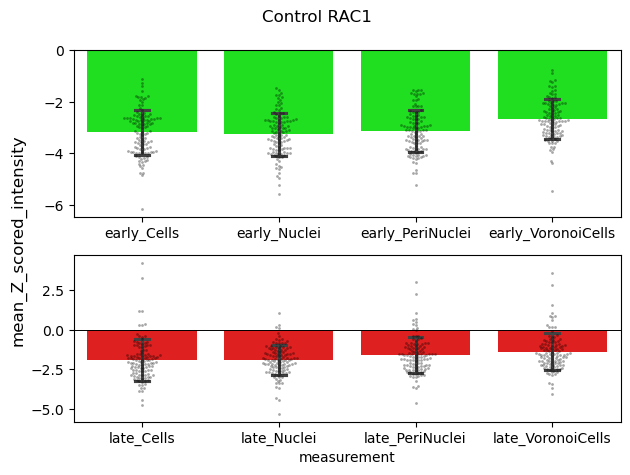

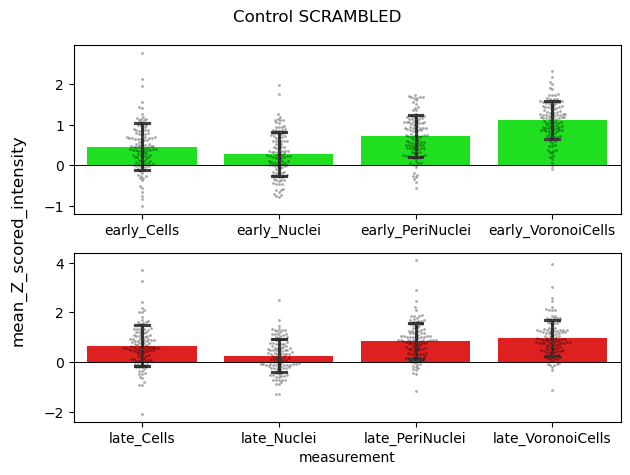

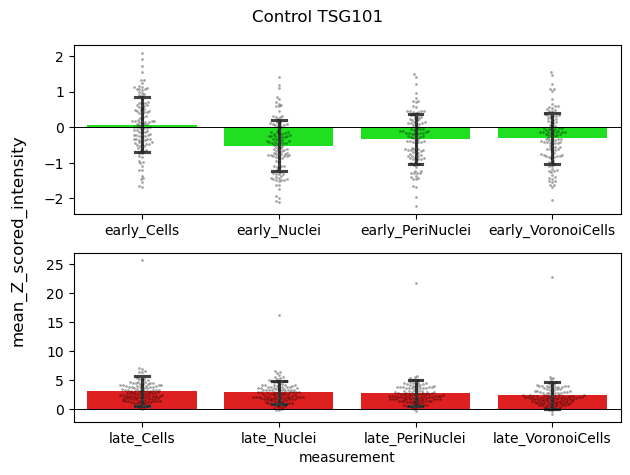

In [13]:
# Generate the plots
generate_bar_plots_with_scatter_per_control(
    dp_g1_g2_b_scored_subset_df,
    "measurement_stability_bar_plots_with_scatter/B-score_normalization",
    capsize=.1,
    markersize=2
)

### Visual Stability Assessment for MAD-Based Z-Scoring

In [18]:
# Load the corresponding version of the subset TSV file
path_to_mad_based_Z_scored_subset_tsv = (
    "Dharmacon_pooled_G1_G2_screening_plates_subset_with_missing_"
    "UniProt_IDs_MAD_based_Z_scoring.tsv"
)

dp_g1_g2_mad_scored_subset_df = pd.read_csv(
    path_to_mad_based_Z_scored_subset_tsv,
    sep="\t"
)

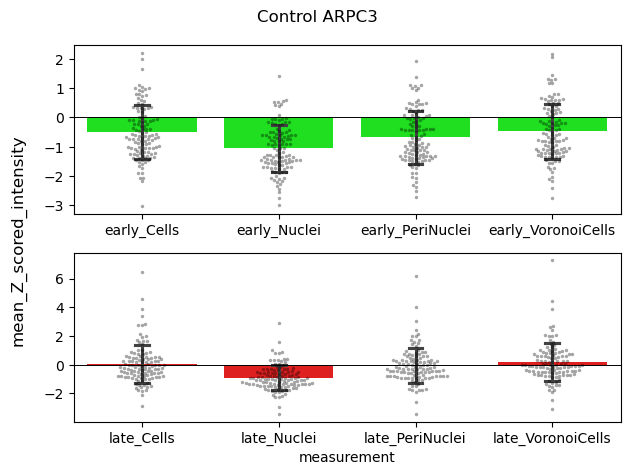

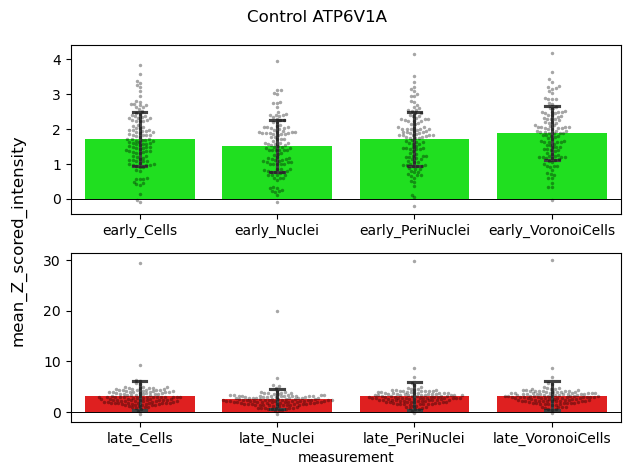

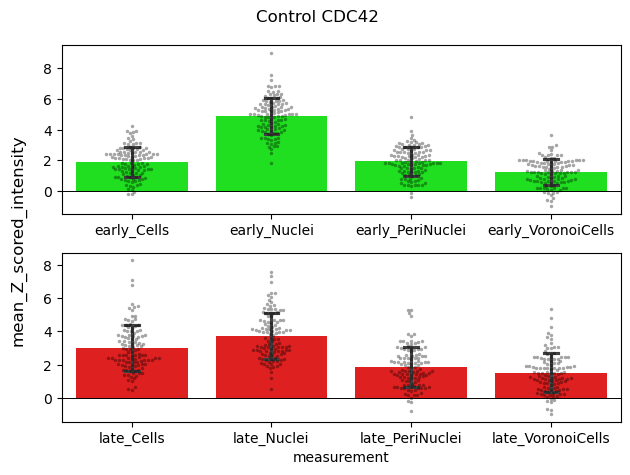

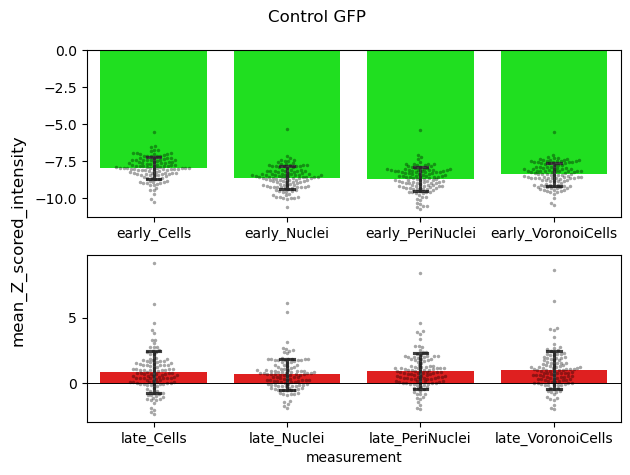

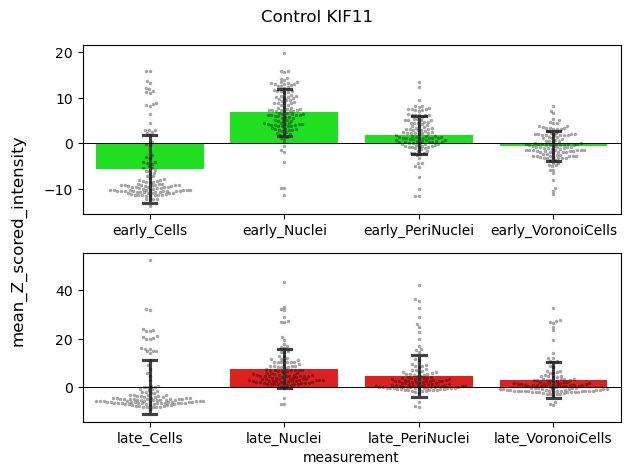

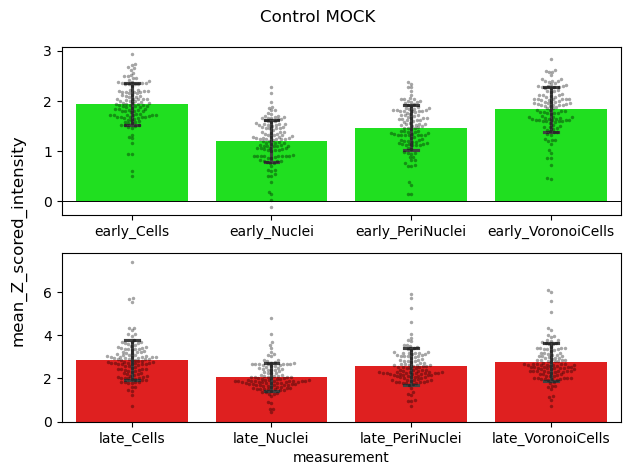

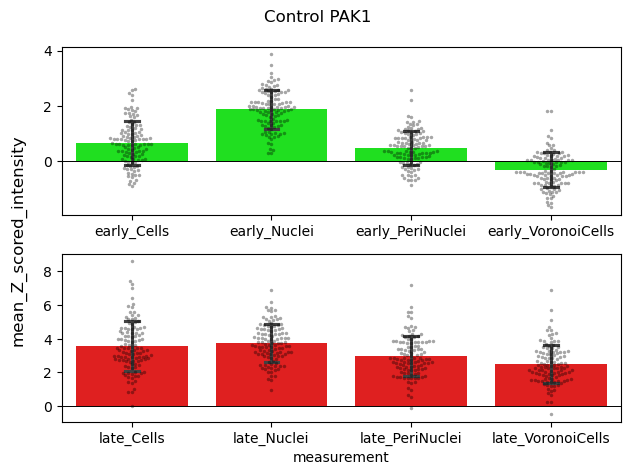

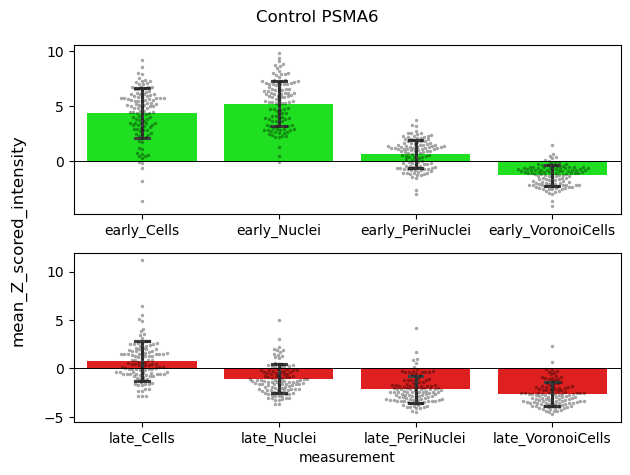

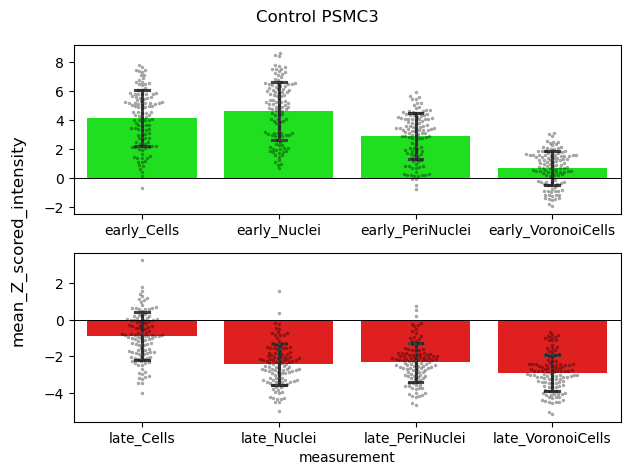

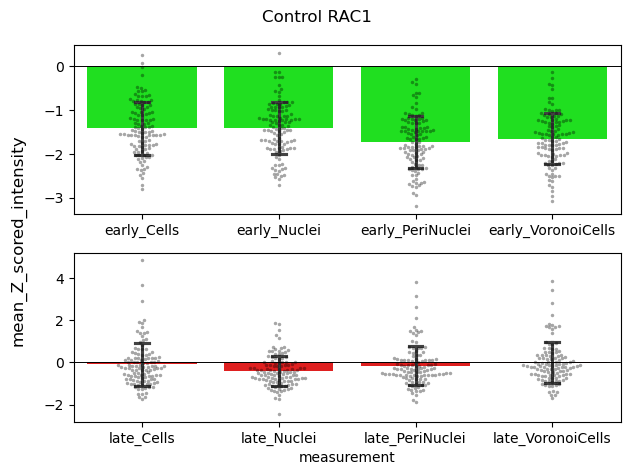

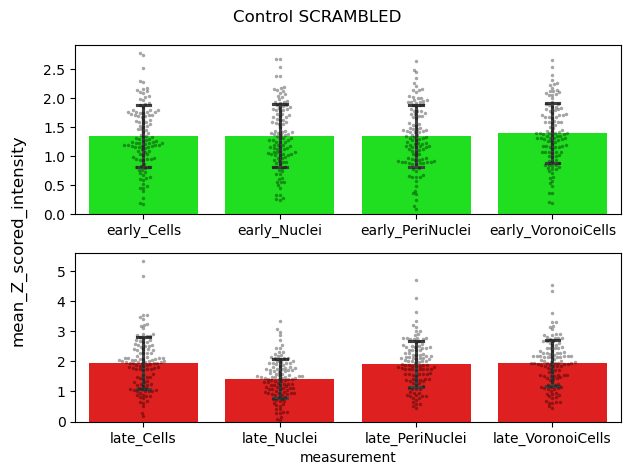

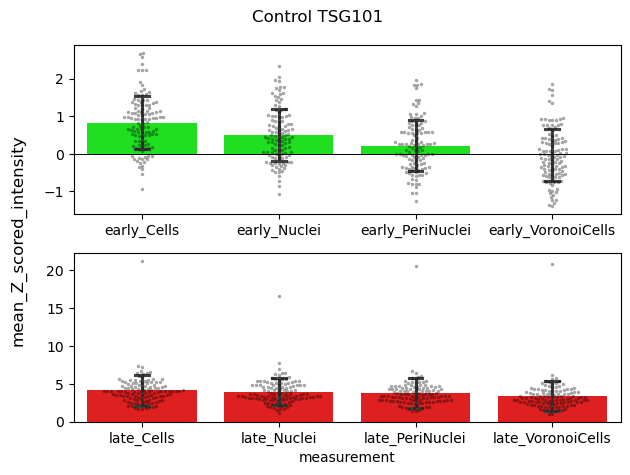

In [19]:
# Generate the plots
generate_bar_plots_with_scatter_per_control(
    dp_g1_g2_mad_scored_subset_df,
    "measurement_stability_bar_plots_with_scatter/MAD-based_Z_scoring",
    capsize=.1
)

### Visual Stability Assessment for IQM Normalization

In [20]:
# Load the corresponding version of the subset TSV file
path_to_iqm_normalized_subset_tsv = (
    "Dharmacon_pooled_G1_G2_screening_plates_subset_with_missing_"
    "UniProt_IDs_IQM_normalized.tsv"
)

dp_g1_g2_iqm_normalized_subset_df = pd.read_csv(
    path_to_iqm_normalized_subset_tsv,
    sep="\t"
)

/opt/homebrew/Caskroom/miniforge/base/envs/bioinformatics/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 14.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/bioinformatics/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 8.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/bioinformatics/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 10.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/bioinformatics/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 14.0% of the points cannot be placed; you may want to decrease the s

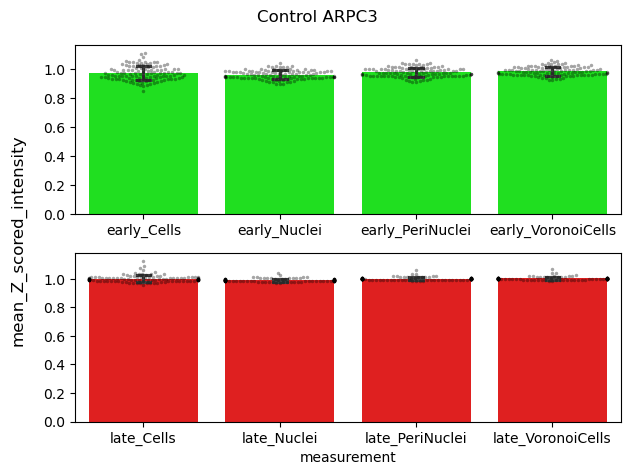

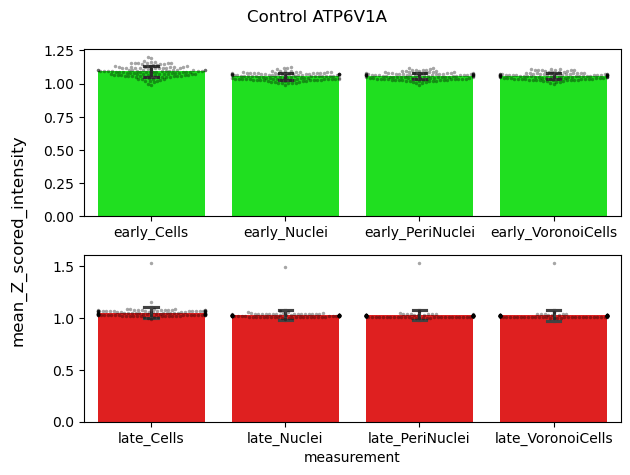

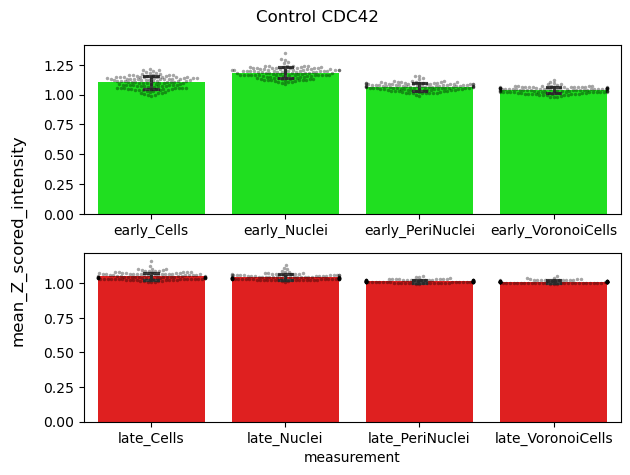

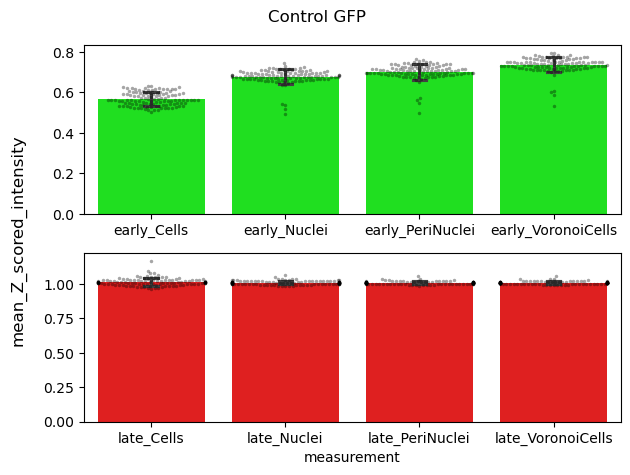

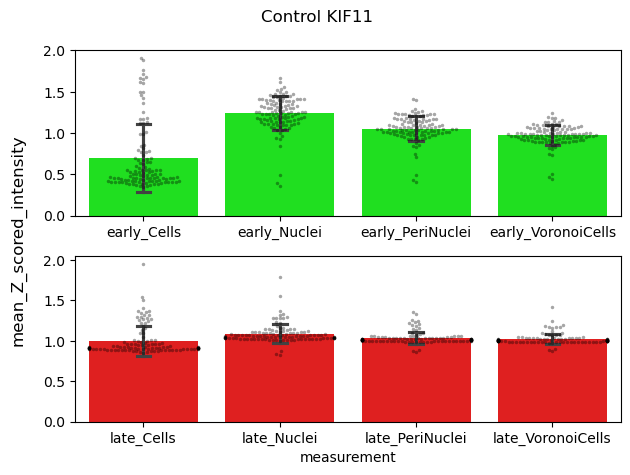

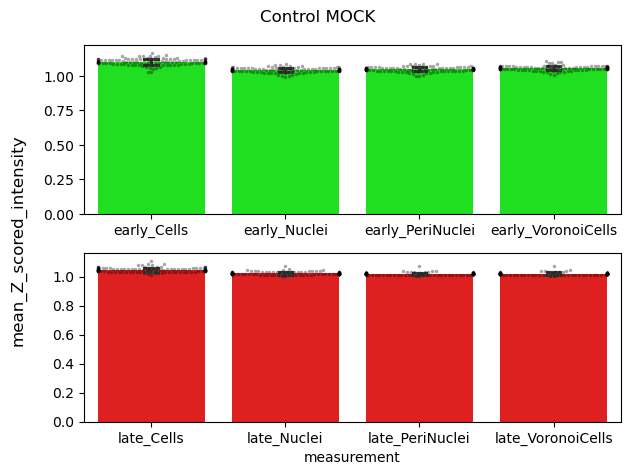

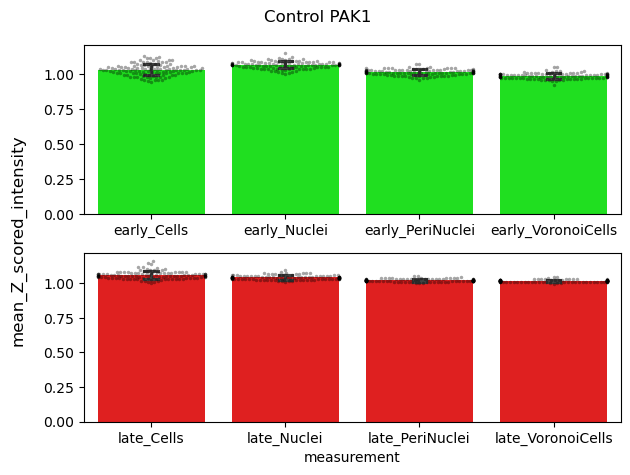

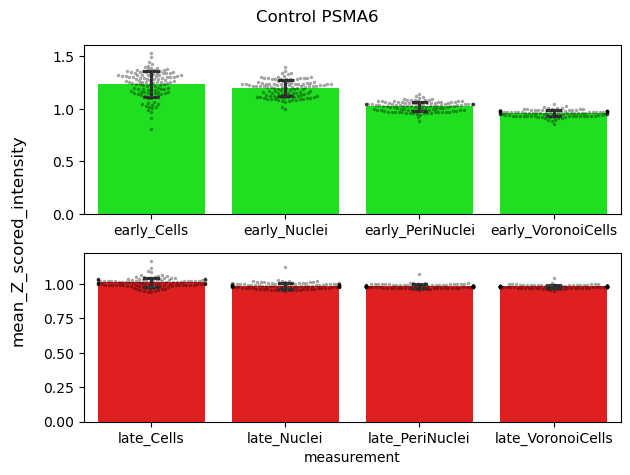

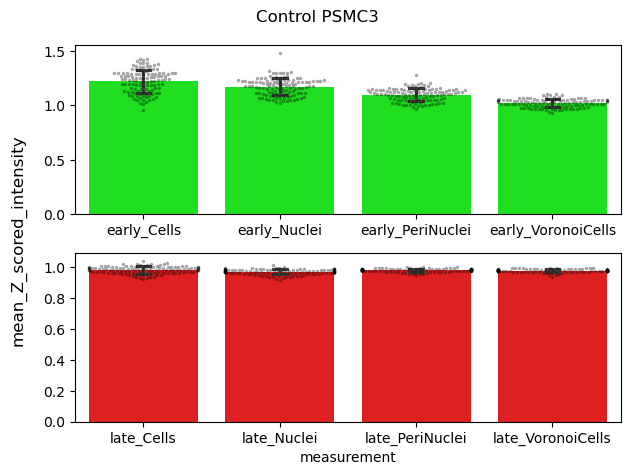

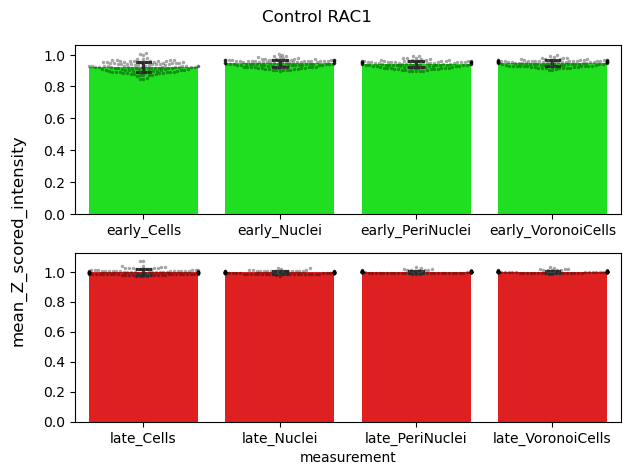

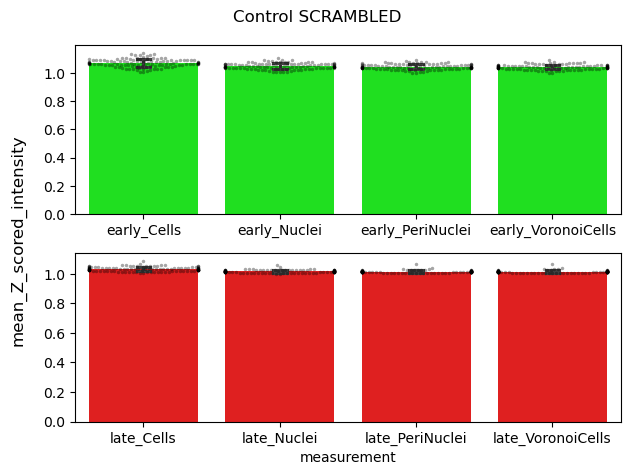

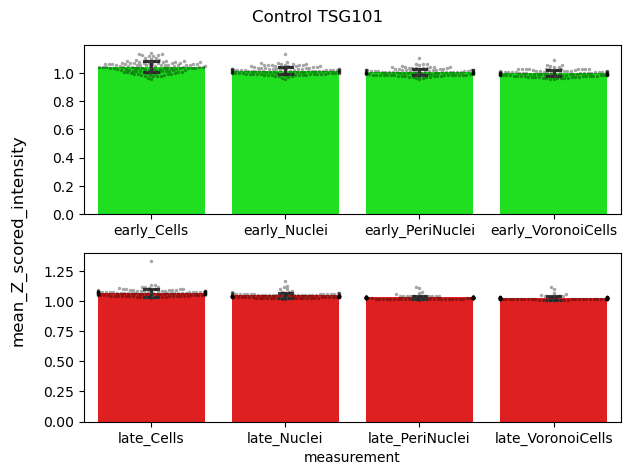

In [21]:
# Generate the plots
generate_bar_plots_with_scatter_per_control(
    dp_g1_g2_iqm_normalized_subset_df,
    "measurement_stability_bar_plots_with_scatter/IQM_normalization",
    capsize=.1
)